# Quality Control

In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

# Setup notebook
nbconfig = Nb.setup_notebook(nb_name='prealn-wf_qc')

# Connect to data store
store = pd.HDFStore('../output/sra.h5')


Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-06-27 
Git hash: 4c20d01e6681b8c7b88b8839bd26945d510a9c60


In [2]:
# Constants
from ncbi_remap.prealn_analysis import (LIBSIZE_CUTOFF, READLEN_CUTOFF, STRAND_CUTOFF1, 
    STRAND_CUTOFF2, UNALIGN_CUTOFF, CONTAMINATION_CUTOFF)

REFERENCES = [
    'phix', 
    'ercc', 
    'dm6', 
    'wolbachia', 
    'yeast', 
    'ecoli', 
    'hg19',
]

complete = store['prealn/complete']
num_samples = complete.shape[0]

Selection of quality samples if the first step of any analysis.
The pre-
alignment workflow uses various quality metrics to identify the most valuable
datasets.
SRA accepts any type of sequencing data including data from low
throughput methods. 
Here I want to focus only on high throughput sequencing
experiments, therefore these quality metrics may identify low throughput methods
as low quality. 
Sequencing quality has also improved over the last 10 years,
which may cause older experiments to fail quality metrics. 
It is also possible
that author's or sequencing centers may include lower quality datasets for
completeness.

In [3]:
Markdown(f"""
## Library Size

Library size is the number of reads obtained from a sequencing run. 
Over the past decade sequencing technologies have increased library size dramatically. 
For example, typical library sizes for the Illumina GAIIx was ~42 mil reads per lane, while the more recent HiSeq X can produce 375 mil reads per lane. 
However, multiplexing has also become more feasible, splitting reads across multiple samples that have been mixed together. 
Here we focus on libraries that have at least {LIBSIZE_CUTOFF:,.0f} reads. 

**Note: during the download process I consider a sample failing download if its library size ≤1,000 reads.**
""")



## Library Size

Library size is the number of reads obtained from a sequencing run. 
Over the past decade sequencing technologies have increased library size dramatically. 
For example, typical library sizes for the Illumina GAIIx was ~42 mil reads per lane, while the more recent HiSeq X can produce 375 mil reads per lane. 
However, multiplexing has also become more feasible, splitting reads across multiple samples that have been mixed together. 
Here we focus on libraries that have at least 100,000 reads. 

**Note: during the download process I consider a sample failing download if its library size ≤1,000 reads.**


/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


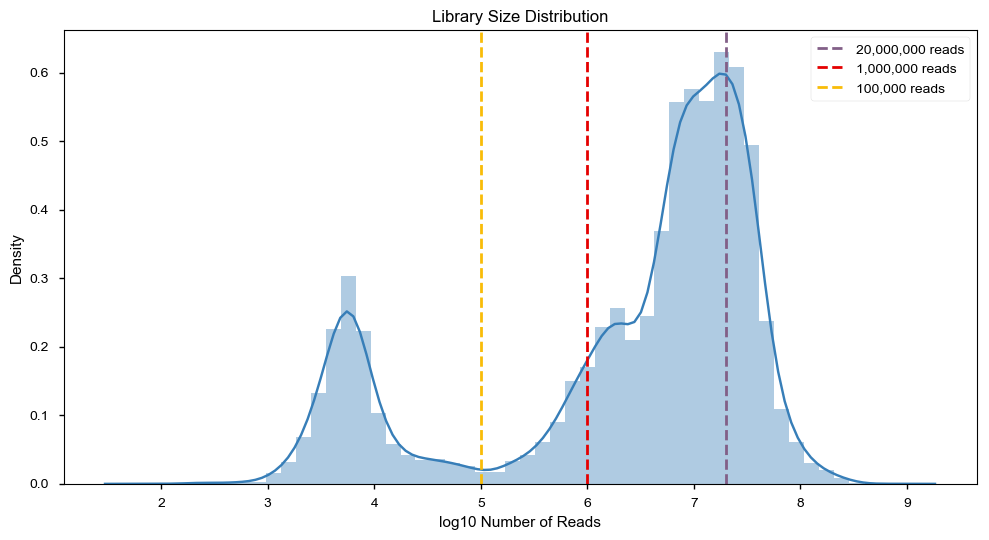

In [4]:
# Plot distribution of libsizes
@make_figs(nbconfig.fig_name('distplot_libsize'), 
           styles=nbconfig.styles_wide, formats=nbconfig.formats)
def plot(store):
    sr = store['prealn/workflow/fastq']['libsize_R1']
    fig, ax = plt.subplots(1, 1)
    sns.distplot(np.log10(sr), ax=ax)
    ax.axvline(np.log10(2e7), ls='--', lw=2, color=nbconfig.color_c2, label='20,000,000 reads')
    ax.axvline(np.log10(1e6), ls='--', lw=2, color=nbconfig.color_c1, label='1,000,000 reads')
    ax.axvline(np.log10(1e5), ls='--', lw=2, color=nbconfig.color_c3, label='100,000 reads')
    ax.legend()
    ax.set_xlabel('log10 Number of Reads')
    ax.set_ylabel('Density')
    ax.set_title('Library Size Distribution');
    return fig

plot(store)

In [5]:
# Make flags
from ncbi_remap.prealn_analysis import libsize, libsize_cnts
libsize_ok = libsize(store, cutoff=LIBSIZE_CUTOFF)
libsize_million = libsize(store, cutoff=1e6)

# Summary
n_samples = '{:,}'.format(num_samples)
n_gt_million = '{:,}'.format(libsize_million.shape[0])
n_gt_ok = '{:,}'.format(libsize_ok.shape[0])
cutoff = '{:,.0f}'.format(LIBSIZE_CUTOFF)
lmin, lmed, lmax = ['{:,.0f}'.format(x) for x in libsize_cnts(store)]

Markdown(f"""
Of the {n_samples} runs, {n_gt_million} runs have more than 1 million reads. 
The median coverage was {lmed} reads with most runs having less than 20 million reads. 
For the remainder of this project we will focus on the {n_gt_ok} runs that have ≥{cutoff} reads.

### Criteria

* Library Size ≥{cutoff} reads

### Summary

<table class="table table-striped">
    <tr><th>Library Size</th><th>Number of Reads</td></tr>
    <tr><td>Min</td><td>{lmin}</td></tr>
    <tr><td>Median</td><td>{lmed}</td></tr>
    <tr><td>Max</td><td>{lmax}</td></tr>
    <tr><td><strong>Runs ≥{cutoff}</strong></td><td>{n_gt_ok} (SRRs)</td></tr>
</table>

""")


Of the 33,635 runs, 24,981 runs have more than 1 million reads. 
The median coverage was 7,183,119 reads with most runs having less than 20 million reads. 
For the remainder of this project we will focus on the 27,268 runs that have ≥100,000 reads.

### Criteria

* Library Size ≥100,000 reads

### Summary

<table class="table table-striped">
    <tr><th>Library Size</th><th>Number of Reads</td></tr>
    <tr><td>Min</td><td>73</td></tr>
    <tr><td>Median</td><td>7,183,119</td></tr>
    <tr><td>Max</td><td>745,596,549</td></tr>
    <tr><td><strong>Runs ≥100,000</strong></td><td>27,268 (SRRs)</td></tr>
</table>



## Read Length

Similar to library size, read lengths have also increased over
the past decade. 
Early Illumina read lengths were ~30 bp long, while recent
read lengths can be over 150 bp. 
However, the extra cost associated with extra
read length are not always justified, so many labs still sequence using shorter
read lengths. 

**Note: during the download process I consider a sample failing
download if its average read length was ≤10 bp.**

/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


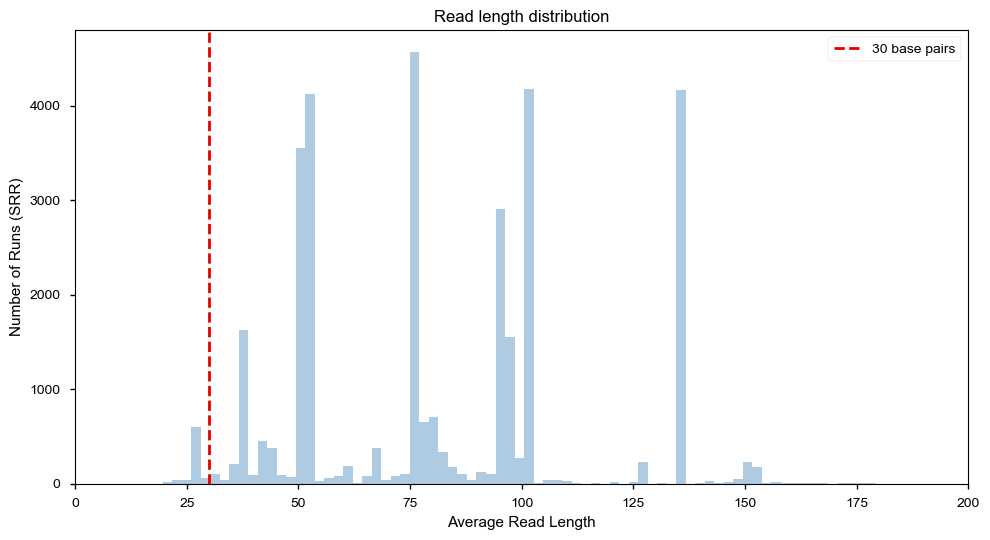

In [6]:
# Plot distribution of read lengths
@make_figs(nbconfig.fig_name('distplot_readLen'), 
           styles=nbconfig.styles_wide, formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/fastq'][['avgLen_R1', 'avgLen_R2']]
    df['len'] = df[['avgLen_R1', 'avgLen_R2']].max(axis=1)

    fig, ax = plt.subplots(1, 1)
    sns.distplot(df.len, bins=500, ax=ax, kde=False, hist_kws={"align": 'right'})
    ax.set_xlabel('Average Read Length')
    ax.set_ylabel('Number of Runs (SRR)')
    ax.set_xlim(0, 200)
    ax.set_title('Read length distribution');
    ax.axvline(READLEN_CUTOFF, ls='--', lw=2, color=nbconfig.color_c1, label='{} base pairs'.format(READLEN_CUTOFF))
    ax.legend()
    
    return fig

plot(store)

In [7]:
# Make flags
from ncbi_remap.prealn_analysis import readlen, readlen_cnts
readlen_ok = readlen(store, cutoff=READLEN_CUTOFF)
readlen_gt_200 = readlen(store, cutoff=200)

# Summary
cutoff = '{:.0f}'.format(READLEN_CUTOFF)
n_gt_cutoff = '{:,}'.format(readlen_ok.shape[0])
n_gt_200 = '{:,}'.format(readlen_gt_200.shape[0])

lmin, lmed, lmode, lmax = ['{:,.0f}'.format(x) for x in readlen_cnts(store)]

Markdown(f"""
There are {n_gt_cutoff} runs that have an average read length ≥{cutoff} bp. 
Looking at the distribution of read lengths, {lmode} bp is the most popular read length with more than >3,500 runs, followed by 76 bp with more than 3,000 runs. 
There are {n_gt_200} runs with a read length ≥200 bp.

### Criteria
* ≥{cutoff} bp

### Summary

<table class="table table-striped">
    <tr><th>Avg Read Length</th> <th>Read Length</th></tr>
    <tr><td>Min</td><td>{lmin}</td></tr>
    <tr><td>Median</td><td>{lmed}</td></tr>
    <tr><td>Mode</td><td>{lmode}</td></tr>
    <tr><td>Max</td><td>{lmax}</td></tr>
    <tr><td><strong>Runs ≥{cutoff} bp</strong></td><td>{n_gt_cutoff} (SRRs)</td></tr>
</table>

""")


There are 32,846 runs that have an average read length ≥30 bp. 
Looking at the distribution of read lengths, 51 bp is the most popular read length with more than >3,500 runs, followed by 76 bp with more than 3,000 runs. 
There are 111 runs with a read length ≥200 bp.

### Criteria
* ≥30 bp

### Summary

<table class="table table-striped">
    <tr><th>Avg Read Length</th> <th>Read Length</th></tr>
    <tr><td>Min</td><td>10</td></tr>
    <tr><td>Median</td><td>76</td></tr>
    <tr><td>Mode</td><td>51</td></tr>
    <tr><td>Max</td><td>1,075</td></tr>
    <tr><td><strong>Runs ≥30 bp</strong></td><td>32,846 (SRRs)</td></tr>
</table>



## Stranded

Strandedness is determined by the library construction protocol,
with the majority of samples likely to be from an unstranded protocol, followed
by second stranded (e.g. Illumina's stranded protocol). 
Library strandedness is
an important metric to decide which runs are useful for different purposes
(e.g., annotation or splicing). 
Strandedness is also used as common alignment
and coverage count parameter.

To determine strandedness, reads were aligned in
unstranded mode with `hisat2`. 
Alignments were then processed with Picard's
`CollectRNASeqMetrics` using three separate modes (First stranded, Second
stranded, Unstranded). 
In First stranded mode, reads are expected to map to the
same strand as the gene model. 
In Second stranded mode, reads are expected to
map to the opposite strand. 
Finally in unstranded mode reads are expected to
map equally to both strands. 
Picard reports the proportion of reads that map to
the "correct" strand. 
We use this proportion as a metric for strandedness.
While not strictly a quality control metric, if a stranded protocol was
attempted, incomplete strandedness could indicate potential problems during
library preparation.

/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


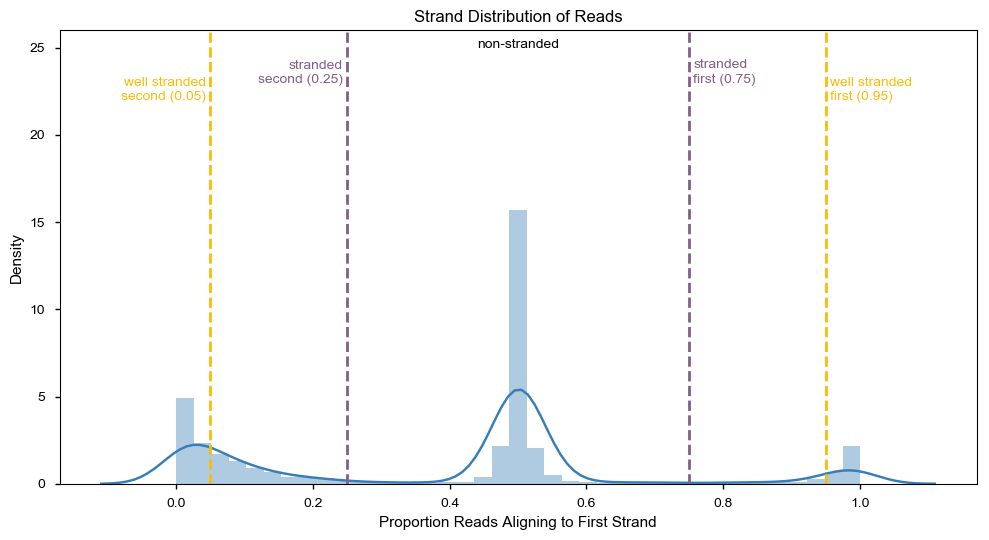

In [8]:
# Plot distribution of strandedness
@make_figs(nbconfig.fig_name('distplot_strandedness'), styles=nbconfig.styles_wide, formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/collectrnaseqmetrics/first']
    c1 = nbconfig.color_c1
    c2 = nbconfig.color_c2
    c3 = nbconfig.color_c3
    
    fig, ax = plt.subplots(1, 1)
    sns.distplot(df.PCT_CORRECT_STRAND_READS, ax=ax)
    ax.set_title('Strand Distribution of Reads')
    ax.set_xlabel('Proportion Reads Aligning to First Strand')
    ax.set_ylabel('Density')
    ax.axvline(STRAND_CUTOFF1, ls='--', lw=2, color=c2)
    ax.axvline(1 - STRAND_CUTOFF1, ls='--', lw=2, color=c2)
    ax.axvline(STRAND_CUTOFF2, ls='--', lw=2, color=c3)
    ax.axvline(1 - STRAND_CUTOFF2, ls='--', lw=2, color=c3)

    _ct1 = STRAND_CUTOFF1
    _ct2 = 1 - STRAND_CUTOFF1
    ax.annotate(xy=(_ct1, 23), s='stranded\nfirst ({:.2f})'.format(_ct1), xytext=(3, 0), textcoords='offset points', color=c2)
    ax.annotate(xy=(_ct2, 23), s='stranded\nsecond ({:.2f})'.format(_ct2), ha='right', xytext=(-3, 0), textcoords='offset points', color=c2)

    _ct1 = STRAND_CUTOFF2
    _ct2 = 1 - STRAND_CUTOFF2
    ax.annotate(xy=(_ct1, 22), s='well stranded\nfirst ({:.2f})'.format(_ct1), xytext=(3, 0), textcoords='offset points', color=c3)
    ax.annotate(xy=(_ct2, 22), s='well stranded\nsecond ({:.2f})'.format(_ct2), ha='right', xytext=(-3, 0), textcoords='offset points', color=c3)

    ax.annotate(xy=(.5, 25), s='non-stranded', ha='center', color='k')
    ax.set_ylim(0, 26)
    return fig

plot(store)

In [9]:
# Make flags
from ncbi_remap.prealn_analysis import strandedness

def pout(c, f, s, u):
    print("""\
    Cutoff: {:0.2f}
    First Strand: {:,}
    Second Strand: {:,}
    Unstranded: {:,}
    """.format(c, f.shape[0], s.shape[0], u.shape[0]))

f1, s1, u1 = strandedness(store, cutoff=STRAND_CUTOFF1)
f2, s2, u2 = strandedness(store, cutoff=STRAND_CUTOFF2)

# Summary
cutoff1 = '{:.2f}'.format(STRAND_CUTOFF1)
cutoff2 = '{:.2f}'.format(STRAND_CUTOFF2)

n_f_cutoff1 = '{:,}'.format(f1.shape[0])
n_s_cutoff1 = '{:,}'.format(s1.shape[0])
n_u_cutoff1 = '{:,}'.format(u1.shape[0])

n_f_cutoff2 = '{:,}'.format(f2.shape[0])
n_s_cutoff2 = '{:,}'.format(s2.shape[0])
n_u_cutoff2 = '{:,}'.format(u2.shape[0])

Markdown(f"""
For First stranded mode, we look at the proportion of reads aligning to correct strand (PCT_CORRECT_STRAND_READS). 
Unstranded runs have approximately 50% of reads mapping to the first strand. 
First stranded runs have the majority of reads mapping to the correct strand. 
Second stranded runs have few reads mapping to the first strand. 
Here we selected two cutoffs ({cutoff1}, {cutoff2}). 
For setting alignment criteria we used less stringent {cutoff1}. 
While {cutoff2} are well stranded runs that would be more appropriate for looking annotations. 

### Criteria
* ≥{cutoff1} reads correct strand
* ≥{cutoff2} reads correct strand

### Summary

**≥{cutoff1} reads correct strand**

<table>
<tr><th>Strandedness</th><th>Number of Runs</th></tr>
<tr><td>First Strand</td><td>{n_f_cutoff1}</td></tr>
<tr><td>Second Strand</td><td>{n_s_cutoff1}</td></tr>
<tr><td>Unstranded</td><td>{n_u_cutoff1}</td></tr>
</table>


**≥{cutoff2} reads correct strand**

<table>
<tr><th>Strandedness</th><th>Number of Runs</th></tr>
<tr><td>First Strand</td><td>{n_f_cutoff2}</td></tr>
<tr><td>Second Strand</td><td>{n_s_cutoff2}</td></tr>
<tr><td>Unstranded</td><td>{n_u_cutoff2}</td></tr>
</table>

""")


For First stranded mode, we look at the proportion of reads aligning to correct strand (PCT_CORRECT_STRAND_READS). 
Unstranded runs have approximately 50% of reads mapping to the first strand. 
First stranded runs have the majority of reads mapping to the correct strand. 
Second stranded runs have few reads mapping to the first strand. 
Here we selected two cutoffs (0.75, 0.95). 
For setting alignment criteria we used less stringent 0.75. 
While 0.95 are well stranded runs that would be more appropriate for looking annotations. 

### Criteria
* ≥0.75 reads correct strand
* ≥0.95 reads correct strand

### Summary

**≥0.75 reads correct strand**

<table>
<tr><th>Strandedness</th><th>Number of Runs</th></tr>
<tr><td>First Strand</td><td>3,158</td></tr>
<tr><td>Second Strand</td><td>11,344</td></tr>
<tr><td>Unstranded</td><td>19,133</td></tr>
</table>


**≥0.95 reads correct strand**

<table>
<tr><th>Strandedness</th><th>Number of Runs</th></tr>
<tr><td>First Strand</td><td>2,427</td></tr>
<tr><td>Second Strand</td><td>6,168</td></tr>
<tr><td>Unstranded</td><td>25,040</td></tr>
</table>



## Mappability

Next we look at how well reads align to the reference genome
(FlyBase release 6), a.k.a. mappability. 
Independent of the library strategy,
we may expect that the majority of reads should map to the reference genome. 
A
large fraction of unaligned reads indicate either issues with library
construction or an incorrect reference genome. 
There are known instances where
libraries were constructed by mixing multiple species, but these are rare and in
our experience species specific reads are separated prior to upload. 
Therefore
we look to exclude runs that have excessive amounts of unaligned reads.

/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwar

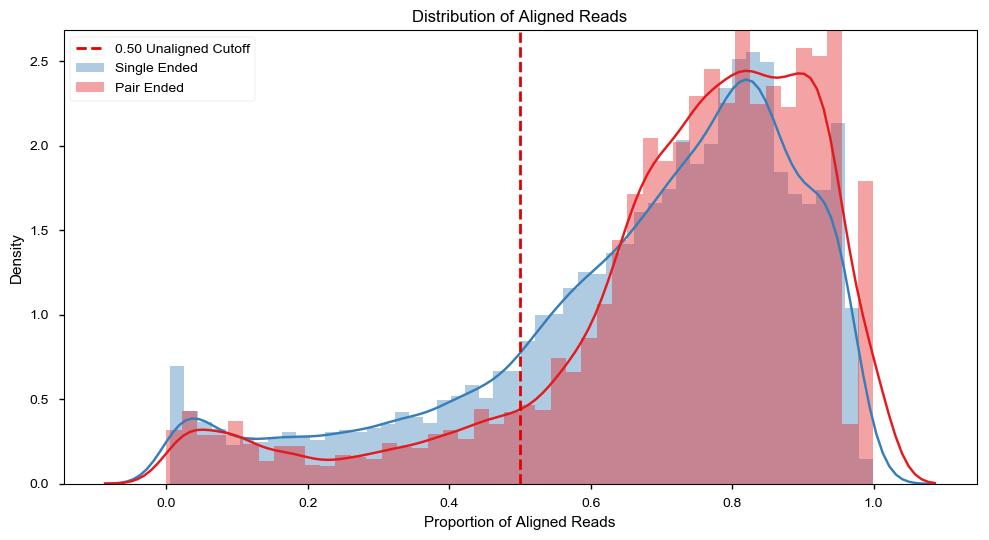

In [10]:
# Plot distribution of unmapped reads.
@make_figs(nbconfig.fig_name('distplot_unaligned'), styles=nbconfig.styles_wide, 
           formats=nbconfig.formats)
def plot(store):
    se = store['prealn/workflow/hisat2'][['num_reads', 'num_reads_unpaired', 'num_unaligned']]
    se.dropna(inplace=True)
    se['prop_aligned'] = 1 - (se['num_unaligned'] / se['num_reads'])

    pe = store['prealn/workflow/hisat2'][['num_reads', 'num_reads_paired', 'num_concordant_reads_unaligned']]
    pe.dropna(inplace=True)
    pe['prop_aligned'] = 1 - (pe['num_concordant_reads_unaligned'] / pe['num_reads'])

    fig, ax = plt.subplots(1, 1)
    sns.distplot(se.prop_aligned, ax=ax, label='Single Ended')
    sns.distplot(pe.prop_aligned, ax=ax, label='Pair Ended')
    ax.axvline(UNALIGN_CUTOFF, color=nbconfig.color_c1, ls='--', lw=2, label='{:0.2f} Unaligned Cutoff'.format(UNALIGN_CUTOFF))
    ax.legend()
    ax.set_title('Distribution of Aligned Reads')
    ax.set_xlabel('Proportion of Aligned Reads')
    ax.set_ylabel('Density');
    
plot(store)

In [11]:
# Make flags
from ncbi_remap.prealn_analysis import mappability
mapping_ok = mappability(store, cutoff=UNALIGN_CUTOFF)

# Summary
cutoff = '{:.0f}'.format(UNALIGN_CUTOFF * 100)
n_gt_cutoff = '{:,.0f}'.format(mapping_ok.shape[0])
n_lt_cutoff = '{:,.0f}'.format(num_samples - mapping_ok.shape[0])

Markdown(f"""
The majority of runs (n={n_gt_cutoff}) had less than {cutoff}% of reads unaligned. 
Single-End and Pair-End runs show similar distributions of unaligned reads.  

### Criteria

* ≥{cutoff}% reads aligned

### Summary

<table>
<tr><th>Percent Aligned</th><th>Number of Runs</th></tr>
<tr><td>≥{cutoff}%</td><td>{n_gt_cutoff}</td></tr>
<tr><td><{cutoff}%</td><td>{n_lt_cutoff}</td></tr>
</table>

""")

../lib/ncbi_remap/prealn_analysis.py:223: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  df = pd.concat([se, pe])



The majority of runs (n=27,616) had less than 50% of reads unaligned. 
Single-End and Pair-End runs show similar distributions of unaligned reads.  

### Criteria

* ≥50% reads aligned

### Summary

<table>
<tr><th>Percent Aligned</th><th>Number of Runs</th></tr>
<tr><td>≥50%</td><td>27,616</td></tr>
<tr><td><50%</td><td>6,019</td></tr>
</table>



## Sequence Contamination

In any experiment there is always a chance for contamination. 
Typically we know
potential sources of contamination. 
However, when dealing with public data it
is impossible to know these details. 
To get a better understanding on potential
problems we mapped a subset of reads to different references. 
These references
include technical references that would be introduced on purpose (ERCC, phiX
controls), and biological references that may or may not have been introduced on
purpose (yeast, wolbachia, ecoli, and human). 
We expect that the majority of
reads should map preferentially to the Drosophila reference (dm6), and excessive
amounts of mapping to another reference my indicate contamination. 
Reads were
summarized into different classes based on if reads align to a single or
multiple locations within a references and if they align to a single or multiple
references.

### One Hit One Reference

/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


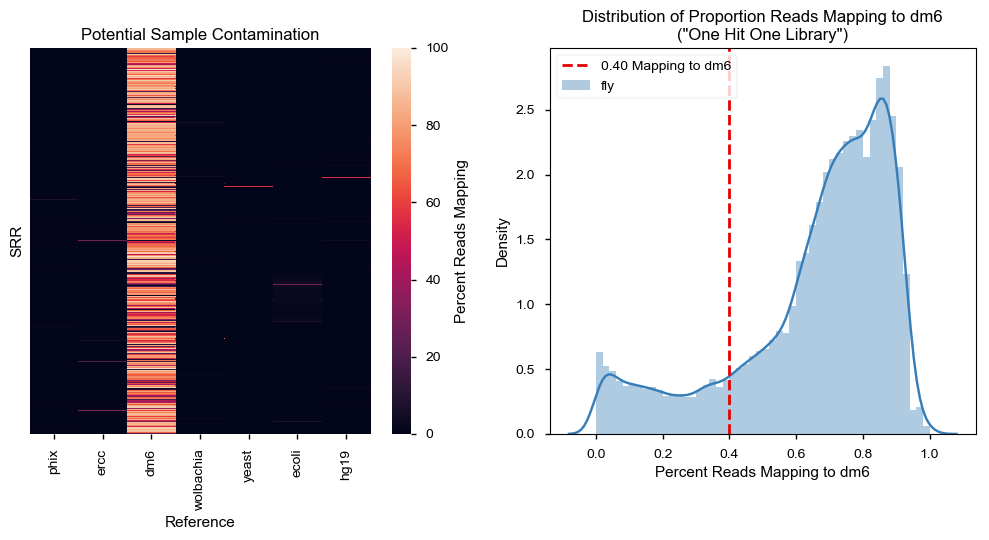

In [12]:
# Plot heatmap of one hit one species
@make_figs(nbconfig.fig_name('heatmap_distplot_contamination'), styles=nbconfig.styles_wide, 
           formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/fastq_screen']
    df.reset_index(inplace=True)
    df = df[['srx', 'srr', 'reference', 'one_hit_one_library_percent']].set_index(['srx', 'srr', 'reference']).dropna().unstack()
    df.columns = df.columns.droplevel(0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.heatmap(df[REFERENCES], yticklabels=False, cbar_kws={'label': 'Percent Reads Mapping'}, ax=ax1)
    ax1.set_title('Potential Sample Contamination');
    ax1.set_ylabel('SRR');
    ax1.set_xlabel('Reference');

    # Plot distirbution of major categories
    sns.distplot(df.dm6 / 100, label='fly', ax=ax2)
    plt.title('Distribution of Proportion Reads Mapping to dm6\n("One Hit One Library")');
    ax2.set_xlabel('Percent Reads Mapping to dm6')
    ax2.set_ylabel('Density')
    ax2.axvline(CONTAMINATION_CUTOFF / 100, color=nbconfig.color_c1, ls='--', lw=2, 
                label='{:0.2f} Mapping to dm6'.format(CONTAMINATION_CUTOFF / 100))
    ax2.legend()
    
    return fig

plot(store)

In [13]:
# Create summary table showing the number of samples whose majority of 
# reads came from a specific reference.
def summary(store):
    df = store['prealn/workflow/fastq_screen']
    df.reset_index(inplace=True)
    df = df[['srx', 'srr', 'reference', 'one_hit_one_library_percent']].set_index(['srx', 'srr', 'reference']).dropna().unstack()
    df.columns = df.columns.droplevel(0)
    df = df[REFERENCES]

    table = df.apply(lambda x: x.values.argmax(), axis=1).value_counts()
    table.index = df.columns[table.index]
    table['total'] = table.sum()
    table = table.map(lambda x: '{:,}'.format(x)).to_frame()

    table.columns = ['Number of Samples']
    
    return table

def summary2(store):
    df = store['prealn/workflow/fastq_screen']
    df.reset_index(inplace=True)
    df = df[['srx', 'srr', 'reference', 'one_hit_one_library_percent']].set_index(['srx', 'srr', 'reference']).dropna().unstack()
    df.columns = df.columns.droplevel(0)
    df = df[REFERENCES]

    table = (df > 0).sum()
    table = table.sort_values(ascending=False)
    table = table.map(lambda x: '{:,}'.format(x)).to_frame()
    table.columns = ['Number of Samples']
    
    return table

df = summary(store)
df2 = summary2(store)

Markdown(f"""
Here I focus on reads that mapped to one location in one reference. 

### Criteria

* ≥{CONTAMINATION_CUTOFF}% reads aligning to dm6


### Summary

#### Primary Reference

First we consider which reference had the majority of reads (mapping to one location) going to it. 
In other words, there were {df.loc['hg19', 'Number of Samples']} samples were the majority of reads that mapped to a single location went to hg19.

{df.to_html(classes="table table-striped")}

#### Any Mapping
Second we see how many samples had any number of reads (mapping to one location) going all references. 
In other words, there were {df2.loc['ercc', 'Number of Samples']} samples with evidence of ercc spikeins.

{df2.to_html(classes="table table-striped")}

""")


Here I focus on reads that mapped to one location in one reference. 

### Criteria

* ≥40% reads aligning to dm6


### Summary

#### Primary Reference

First we consider which reference had the majority of reads (mapping to one location) going to it. 
In other words, there were 50 samples were the majority of reads that mapped to a single location went to hg19.

<table border="1" class="dataframe table table-striped">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Number of Samples</th>
    </tr>
    <tr>
      <th>reference</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>dm6</th>
      <td>33,157</td>
    </tr>
    <tr>
      <th>yeast</th>
      <td>206</td>
    </tr>
    <tr>
      <th>ecoli</th>
      <td>122</td>
    </tr>
    <tr>
      <th>hg19</th>
      <td>50</td>
    </tr>
    <tr>
      <th>phix</th>
      <td>48</td>
    </tr>
    <tr>
      <th>ercc</th>
      <td>40</td>
    </tr>
    <tr>
      <th>wolbachia</th>
      <td>6</td>
    </tr>
    <tr>
      <th>total</th>
      <td>33,629</td>
    </tr>
  </tbody>
</table>

#### Any Mapping
Second we see how many samples had any number of reads (mapping to one location) going all references. 
In other words, there were 5,660 samples with evidence of ercc spikeins.

<table border="1" class="dataframe table table-striped">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Number of Samples</th>
    </tr>
    <tr>
      <th>reference</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>dm6</th>
      <td>33,594</td>
    </tr>
    <tr>
      <th>hg19</th>
      <td>19,620</td>
    </tr>
    <tr>
      <th>ecoli</th>
      <td>12,597</td>
    </tr>
    <tr>
      <th>phix</th>
      <td>11,038</td>
    </tr>
    <tr>
      <th>yeast</th>
      <td>7,497</td>
    </tr>
    <tr>
      <th>wolbachia</th>
      <td>6,785</td>
    </tr>
    <tr>
      <th>ercc</th>
      <td>5,660</td>
    </tr>
  </tbody>
</table>



In [14]:
# Make flags
from ncbi_remap.prealn_analysis import contamination
contamination_ok = contamination(store, cutoff=CONTAMINATION_CUTOFF)

# Summary
cutoff = f'{CONTAMINATION_CUTOFF:.0f}'
n_gt_cutoff = f'{contamination_ok.shape[0]:,.0f}'

Markdown(f"""
I require at least {cutoff}% of reads map to the Drosophila reference, I have {n_gt_cutoff} samples. 
The remaining samples either had a large number of unaligned reads, a large number of reads mapping to multiple locations, or a large number of reads mapping to other references. 
While some "contamination" may not affect downstream analysis, having almost half of reads going somewhere else is problematic.
""")


I require at least 40% of reads map to the Drosophila reference, I have 28,512 samples. 
The remaining samples either had a large number of unaligned reads, a large number of reads mapping to multiple locations, or a large number of reads mapping to other references. 
While some "contamination" may not affect downstream analysis, having almost half of reads going somewhere else is problematic.


## QC Flags

In [15]:
# Combine all flags and save to store
ok_samples = libsize_ok.merge(
    readlen_ok, on=['srx', 'srr'], how='inner').merge(
    mapping_ok, on=['srx', 'srr'], how='inner').merge(
    contamination_ok, on=['srx', 'srr'], how='inner').merge(
    complete, on=['srx', 'srr'], how='inner'
)

In [16]:
# Add to store
store['prealn/qc_passed'] = ok_samples
n_qc_pass =  '{:,}'.format(ok_samples.shape[0])

Markdown(f"""
There are {n_qc_pass} samples that passed all set QC criteria. 
""")


There are 21,403 samples that passed all set QC criteria. 


In [17]:
store.close()